# PROJECT 2 : TEAM 11

Members: Talia Tandler, SeungU Lyu

In [2]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
import math

http://www.worldometers.info/world-population/us-population/
US pop in 2017 = 324,459,463

https://www.cdc.gov/vaccines/imz-managers/coverage/childvaxview/data-reports/mmr/trend/index.html
MMR immunization rate in 2017 = 90.7%

https://www.acha.org/documents/Programs_Services/ConEd/Measles_Update_2015_Implications_for_the_College_Setting.pdfMMR 
Measles importatoin number = 33/year

https://wwwnc.cdc.gov/travel/yellowbook/2018/infectious-diseases-related-to-travel/measles-rubeola
Measles incubation period 11 days average, infectious period 2-4 days before rash to after rash.

https://www.researchgate.net/figure/Daily-average-number-of-contacts-per-person-in-age-group-j-The-average-number-of_fig2_228649013
Daily average number of contacts per person. 

https://academic.oup.com/jid/article/189/Supplement_1/S91/825077
1999 overall immunity for measles were expected to be 93% for US population.

https://www.statista.com/statistics/195943/birth-rate-in-the-united-states-since-1990/
Birth rate = 12.2/1000 per year = 0.0122 
Death rate = 8.4/1000 per year = 0.0084


In [3]:
us_pop = 324459463  #current US population
init_im = 0.93      #initial immunity of the US population
MMR_vac = .907      #MMR vaccination rate in 2017
a_rate = 0.9        #Possibility of getting measles if you come into contact with someone that has it
b_rate = 0.0122    #US birth rate
d_rate = 0.0084    #US death rate
r_rate = 0.25      #US recovery rate from measles. Typical recovery is 4 days, so 1/4 will recover within 1 day
i_rate = 0.091     #US rate from incubation period of 11 days to infected
c_num = 12         #number of people someone infected comes into contact with

12

# What would be the impact of getting rid of the MMR vaccination in newborn babies over the course of 10 years?

Background/why we thought this was interesting
-Explanation of the disease: symptoms, contagious
- Reference the fake study where the guy said vaccinations are bad for your baby
    --WHAT IF PEOPLE BELIEVED HIM???
- MMR is very super infections and has high herd immunity so when you drop the vaccination rate, it drops the infection rate.

### Methodology

In order to creat this model, we:

1. Did background research on MMR vaccination and the measles diseases and found a set of constants we would implement in our model.
2. Put the variables into a state function.
3. Ran the simulation based on measles infections every day.
4. Expanded simuluation for a course of 10 years.
5. Implemented the idea of a measles outbreak to make the simulation more realistic.
6. Created graphs to visually represent our results.

In [4]:
def make_system (us_pop, init_im, vac_rate, b_rate, d_rate, r_rate, i_rate, c_num, a_rate):
    """Make a system object for the SCIR model
    
    us_pop: Total US population
    init_im: Initial Population Immunity
    vac_rate: Vaccination rate for newborn
    b_rate: birth rate per 1000 people
    d_rate: death rate per 1000 people
    r_rate: recovery rate for infected people
    i_rate: rate of incubation group moving to infectious group
    c_num: initial contact number for individuals 
    a_rate: Possibility of getting measles if you come into contact with someone that has it
    
    return: System object"""
    
    init = State(S = int(us_pop*(1 - init_im)), C = 0, I = 0, R = int(us_pop*init_im), T = 0, O = 0)
    #S: susceptible, C: incubation period, I: infected, R: recovered(immune to disease), T: total infected, O: outbreak status
    
    t0 = 0
    t_end = 365 * 10 #number of days in 10 years
    
    return System(init = init,
                  vac_rate = vac_rate,
                  b_rate = b_rate,
                  d_rate = d_rate,
                  r_rate = r_rate,
                  i_rate = i_rate,
                  c_num = c_num,
                  a_rate = a_rate,
                  t0 = t0,
                  t_end = t_end)

In [22]:
def update_func(state, time, system, contact):
    """Update the SCIR model
    
    state: starting variables of SCIR
    t: time step
    system: includes alpha,beta,gamma,omega rates
    contact: current contact number for the state
    
    """
    
    unpack(system)
    
    s,c,i,r,t,o = state
    
    #posibility of change in C on major outbreak.
    probability = 1 - exp(-0.1*i)
    
    #outbreak status check
    if o == 0 and i >= 3:
        o = 1    #indicates there is a measles outbreak
    
    #if measles outbreak is happening, change the contact number
    if o == 1:
        if flip(probability) and contact > 0:
            contact -= 1
    
    #end the outbreak when balance between C and I happens
    if o == 1 and c <= 10 and i <= 3 and contact == 0:
        c = 0
        i = 0
        o = 0
        contact = c_num
            
    #current population
    current_pop = s+c+i+r
    
    #newborn babies number every day
    newborn = int((b_rate * (current_pop))/365)
    
    #importation of measles from other countries
    if flip(0.09):   #33 people come into the US each year with measles 
        i += 1
        t += 1
    
    #change rate for each status
    ds = int(newborn * (1-vac_rate) - (d_rate * s)/365)  #change in number of people susceptible
    dr1 = int(newborn * vac_rate - (d_rate * r)/365)     #change in number of people recovered/immune due to vaccination or death
    dc = int(contact * i * a_rate * (s/(s+r+c)))         #change in number of people moving to incubation period
    di = int(c * i_rate)                             #change in number of people moving from incubation period to infected
    dr2 = int(i * (r_rate))                        #change in number of people recoverecd/immune from not having measles anymore
  
    s += ds - dc      #number of people susceptible
    i += di - dr2     #number of people infected
    c += dc - di      #number of people in incubation period
    r += dr1 + dr2    #number of recovered people
    t += dc           #number of people in incubation period
    
    return State(S=s, C=c, I=i, R=r, T=t, O=o), contact

In [23]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    unpack(system)
    
    #creates timeframe to save daily states
    frame = TimeFrame(columns=init.index)
    frame.row[t0] = init
    
    #creating contact number with initial value c_num
    contact = c_num
    
    for time in linrange(t0, t_end):
        frame.row[time+1], contact = update_func(frame.row[time], time, system, contact)
    
    return frame

In [24]:
vac_rate = 0.9   #vaccination rate for newborn babies
system = make_system(us_pop, init_im, vac_rate, b_rate, d_rate, r_rate, i_rate, c_num, a_rate)
results = run_simulation(system, update_func)
results;

In [25]:
def sweep_vac(vac_rate_array):
    """Sweep a range of values for beta.
    
    beta_array: array of beta values
    gamma: recovery rate
    
    returns: SweepSeries that maps from beta to total infected
    """
    
    sweep = SweepSeries()
    for vac_rate in vac_rate_array:
        system = make_system(us_pop, init_im, vac_rate, b_rate, d_rate, r_rate, i_rate, c_num, a_rate)
        results = run_simulation(system, update_func)
        sweep[system.vac_rate] = get_last_value(results.T)
    return sweep

In [35]:
def sweep_vac2(vac_rate_array):
    """Sweep a range of values for beta.
    
    beta_array: array of beta values
    gamma: recovery rate
    
    returns: SweepSeries that maps from beta to total infected
    """    
    
    frame2 = TimeFrame(columns=linspace(0,3650,11))
    
    for vac_rate in vac_rate_array:
        system = make_system(us_pop, init_im, vac_rate, b_rate, d_rate, r_rate, i_rate, c_num, a_rate)
        results = run_simulation(system, update_func)
        
        sweep2 = SweepSeries()
        for i in linspace(0,3650, 11):
            sweep2[i] = results.T[i]
            
        frame2.row[vac_rate] = sweep2
    return frame2

In [36]:
vac_rate_array = linspace(0, 1, 11)
frame1 = sweep_vac2(vac_rate_array) 
frame1

,0.0,365.0,730.0,1095.0,1460.0,1825.0,2190.0,2555.0,2920.0,3285.0,3650.0
0.0,0,435,900,1598,2275,2872,3535,4410,5242,6543,7471
0.1,0,397,746,1180,1858,2797,3815,4549,5546,6642,7825
0.2,0,296,676,1175,1746,2525,3258,4140,5089,6162,7111
0.3,0,451,804,1236,1897,2444,3175,4088,4973,5807,6707
0.4,0,355,784,1144,1700,2327,2967,3719,4387,5065,5825
0.5,0,315,673,1047,1493,2062,2509,3218,3993,4588,5369
0.6,0,278,622,1009,1360,1820,2300,2939,3582,4279,4993
0.7,0,312,631,949,1406,1837,2266,2691,3129,3680,4328
0.8,0,288,686,1036,1427,1765,2112,2452,2803,3184,3630
0.9,0,288,706,1109,1395,1776,2173,2534,2817,3271,3655


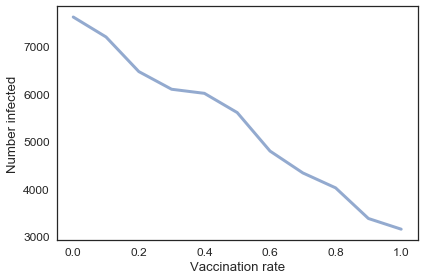

In [10]:
plot(frame)
    
decorate(xlabel='Vaccination rate',
         ylabel='Number infected',
         loc='upper left')

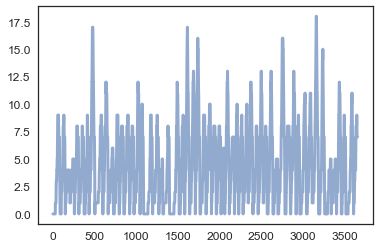

In [11]:
#plot(results['S'], label='R')
plot(results['I'], label='L')
#plot(results['R'], label='E')

In [12]:
test = TimeSeries()
for t in linspace(0,100):
    test[t] = 1 - exp(-0.1*t)
test

,values
0.000000,0.000000
2.040816,0.184604
4.081633,0.335130
6.122449,0.457868
8.163265,0.557947
10.204082,0.639552
12.244898,0.706092
14.285714,0.760349
16.326531,0.804590
18.367347,0.840663
